# Root Finding

Here we will study root finding using some routines from `scipy.optimize`.  Our sample problem will be the shape of a soap film stretched between two rings.  This is a standard problem often encountered when studying the calculus of variations in classical mechanics.

## Initialization

As always we will initialize our environment with everything we need.  Besides the usual inclusion of `numpy` and the relevant module for plotting, we need the routines from `scipy.optimize`.  Also as usual we will give it a short name to make typing easier.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

Before solving a problem we should learn what is available using the introspection capabilities of Jupyter environment.  This includes getting information on the `scipy.optimize` modules, examining a list of functions available, and information on the main functions we will use: `bisect` and `brentq`.

In [ ]:
opt?

In [ ]:
opt.

In [ ]:
opt.bisect?

In [ ]:
opt.brentq?

Notice that `bisect` and `brentq` are called in exactly the same way, making it easy to switch between them.  The main arguments of interest to us will be the function, `f` and the two end points which **must** bracket a root, `a` and `b`.  We will use some of the other arguments, in particular `args`, `xtol`, and `full_output`.

## Soap Film Shape

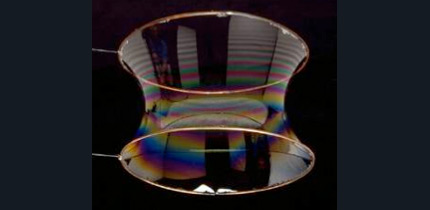

[Image originally from http://www.soapbubble.dk/en/bubbles/geometry.php], though this page appears to have been removed. This image has been inlined into the notebook file.  It may not display when rendered outside of the Jupyter notebook environment.

Consider two rings of radius $R$ with a thin soap film between the two rings.  As the rings are pulled apart the soap film forms the shape shown above and is known as a catenary. A discussion of this interesting problem with both numerical and experimental results is given in a [video by Stand-up Maths](https://www.youtube.com/watch?v=31Om4VrSzb8). He explores more features of the problem than we will here. He also wrote some Python code to numerically solve the problem. As he admits, his code is rather poor. We can do a much better job and could fully solve the problems he poses with much better code!

Focusing on our analysis, if we let $z$ represent an axis through the center of the rings, then the radius of the soap film as a function of the distance along this axis is given by
$$ s(z) = \alpha \cosh\left( \frac{z-\beta}{\alpha} \right), $$
where $\alpha$ and $\beta$ are determined by your initial conditions.

For initial conditions suppose that the bottom ring is at $z=0$ and the top ring is a height $L$ above the bottom one.  Since each ring has a radius $R$ this means that $s(0)=s(L)=R$.  These are our initial conditions.  Using $s(0)=R$ we can show that
$$\beta = \alpha \cosh^{-1}\left(\frac{R}{\alpha}\right), $$
so, if we know $\alpha$ we know $\beta$.  From the condition $s(L)=R$ we find
$$ \alpha \cosh\left[ \frac{L}{\alpha} - \cosh^{-1}\left(\frac{R}{\alpha}\right)\right] = R.$$
Unfortunately we cannot solve this analytically.  This is a transcendental equation and must be solved numerically.

### Basics

To set up for a solution we begin by defining a function (see the prelab for more details). Recall that we want to define a function such that if $x_0$ is a solution, then $f(x_0)=0$.  Further, by default we will consider $L=1.2$ and $R=3$, but these can be changed if desired.  We will include these defaults in the definition of our function, but write a generic function that will work for any choice of $L$ and $R$.

In [2]:
def film_radius(alpha, L=1.2, R=3):
    return alpha * np.cosh(L / alpha - np.arccosh(R / alpha)) - R

To get a quick idea of what this function looks like we should plot it.  A priori we do not know a good range of values to use for $\alpha$ so we should try a few, I have settled on the following. (Note: "Quick tests" or a "quick plot" would normally be fine for this purpose.  Nonetheless, I will use the full, careful way of writing everything out in my examples.)

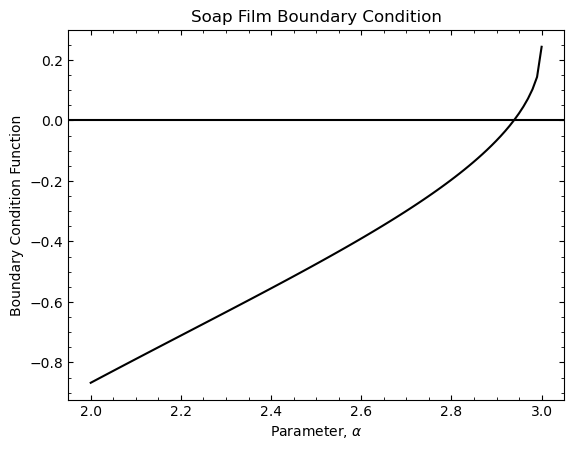

In [3]:
alpha = np.linspace(2, 3, 100)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(alpha, film_radius(alpha), 'k-')
ax.set_xlabel(r'Parameter, $\alpha$')
ax.set_ylabel('Boundary Condition Function')
ax.set_title('Soap Film Boundary Condition')
ax.axhline(0, color='k')
# Fix plot formatting.
# This is another way to "fix" the defaults on a plot-by-plot basis.
ax.minorticks_on()
ax.tick_params(which='both', direction='in', right=True, top=True)

We can see there is a root bounded by this interval, so we will use this interval to find the root.  We can use any method, here are two of them

In [4]:
print('bisection, alpha =', opt.bisect(film_radius, 2, 3))
print('brentq,    alpha =', opt.brentq(film_radius, 2, 3))

bisection, alpha = 2.9385318092263333
brentq,    alpha = 2.9385318092260184


They both give the same answer (for most of the digits printed) which is good.  We can get more information by using the `full_output` keyword.

In [5]:
opt.brentq(film_radius, 2, 3, full_output=True)

(2.9385318092260184,
       converged: True
            flag: 'converged'
  function_calls: 9
      iterations: 8
            root: 2.9385318092260184)

What is this extra information printed?  It is a `RootResults` object that contains information.  What do we do with it? We store it in a variable and use our usual tools, Tab and/or '?', to explore it.

In [6]:
(root, info) = opt.brentq(film_radius, 2, 3, full_output=True)

In [7]:
info

      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 2.9385318092260184

In [ ]:
info.

We can use this to compare the two methods. (This shows two ways of "formatting" output: one using the `format()` function, another using an *f-string*.  We will learn more about this throughout the semester.)

In [8]:
(root_bisect, info_bisect) = opt.bisect(film_radius, 2, 3, full_output=True)
(root_brentq, info_brentq) = opt.brentq(film_radius, 2, 3, full_output=True)
print("Bisect: {} iterations, with {} function calls".format(info_bisect.iterations,
                                                             info_bisect.function_calls))
print(f"Brentq: {info_brentq.iterations} iterations, with {info_brentq.function_calls} function calls")

Bisect: 39 iterations, with 41 function calls
Brentq: 8 iterations, with 9 function calls


### Tolerances

The methods stop when they get "close enough" to the root.  How do they know?  This is where the tolerances come in.  From the documentation you see there are two of them, the main one for our purposes is `xtol`.  What is its default value?  We can set the tolerances as we prefer.  You should rerun the previous comparison with different values set for `xtol`.

### Extra Arguments

The function we defined had three arguments, two of them had default values.  When `bisect` or `brentq` call our function `film_radius` **it only sets the first argument**.  The other two are not set so take on their default values.  Suppose we instead wanted to consider the case where $L=1.7$ and $R=1.5$, how would we do this without redefining our function?  This is done using the `args` keyword.  Note that `args` **should only contain the extra arguments to our function**, not the first argument since `bisect` and `brentq` are making up guesses for the first argument as they work.

To solve for this case we should proceed as above by finding an interval that bounds the root, then finding the root.  Having done so we can find the root using.

In [9]:
root = opt.brentq(film_radius, 0.3, 1, args=(1.7, 1.5))
root

0.45832081874430497

To verify this looks reasonable let us make a plot.

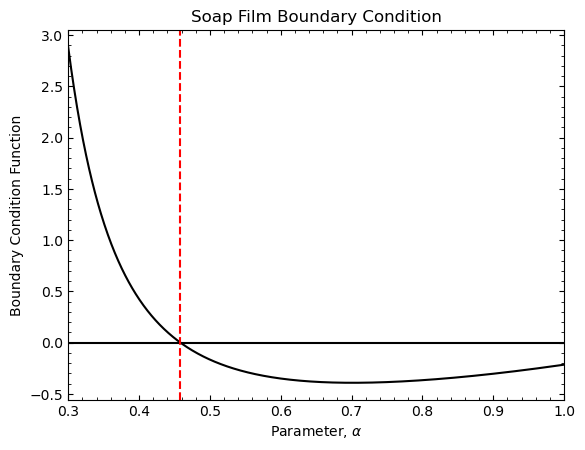

In [10]:
alpha = np.linspace(0.3, 1, 1000)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(alpha, film_radius(alpha, 1.7, 1.5), 'k-')
ax.set_xlabel(r'Parameter, $\alpha$')
ax.set_ylabel('Boundary Condition Function')
ax.set_title('Soap Film Boundary Condition')
ax.axhline(0, color='k')
ax.axvline(root, color='r', ls='--')
ax.minorticks_on()
ax.set_xlim(0.3, 1)
ax.tick_params(which='both', direction='in', right=True, top=True)